In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
from transformers import T5Tokenizer,AutoTokenizer,BertTokenizer,AutoModel
import re
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data.csv')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [ ]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [ ]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)


In [ ]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [ ]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [ ]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [ ]:
y = scores

In [ ]:
vocab_size= len(tokenizer.get_vocab())
vocab_size

33

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

# Define the TCN block with residual connection
class TCNBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, dilation=1, dropout=0.1):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size,
                               padding=(kernel_size - 1) * dilation, dilation=dilation)
        self.norm = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout)

        # If input and output dimensions do not match, apply a 1x1 conv
        self.residual = nn.Conv1d(input_dim, output_dim, kernel_size=1) if input_dim != output_dim else nn.Identity()
        # Add padding to the residual connection to match the output size
        self.residual_padding = nn.ConstantPad1d(((kernel_size - 1) * dilation, 0), 0)  # Apply padding to match the Conv1d output

    def forward(self, x):
        residual = self.residual(x)
        # Apply padding to the residual connection
        residual = self.residual_padding(residual)
        x = self.conv(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x + residual  # Residual connection


class TCNEncoder(nn.Module):
    def __init__(self, vocab_size, model_dim, num_layers, max_len=39, kernel_size=3, dropout=0.1):
        super(TCNEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.tcn_blocks = nn.ModuleList(
            [TCNBlock(model_dim, model_dim, kernel_size, dilation=2**i, dropout=dropout) for i in range(num_layers)]
        )

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, model_dim)
        x = x.transpose(1, 2)  # Change shape to (batch_size, model_dim, seq_len) for Conv1d
        for tcn_block in self.tcn_blocks:
            x = tcn_block(x)
        return x.transpose(1, 2)  # Change back to (batch_size, seq_len, model_dim)


class CrossInteractionLayer(nn.Module):
    def __init__(self, model_dim, dropout=0.1):
        super(CrossInteractionLayer, self).__init__()
        self.conv = nn.Conv1d(model_dim * 2, model_dim, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm1d(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, pep_refined, mhc_refined):
        combined = torch.cat((pep_refined, mhc_refined), dim=-1)  # Shape: (batch_size, seq_len, 2*model_dim)
        combined = combined.transpose(1, 2)  # Change shape to (batch_size, 2*model_dim, seq_len)
        x = self.conv(combined)
        x = self.norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x.transpose(1, 2)  # Change back to (batch_size, seq_len, model_dim)


class TCNModel(nn.Module):
    def __init__(self, model_dim, num_layers, dropout=0.1, vocab_size=33):
        super(TCNModel, self).__init__()
        self.encoder_pep = TCNEncoder(vocab_size, model_dim, num_layers, dropout=dropout)
        self.encoder_mhc = TCNEncoder(vocab_size, model_dim, num_layers, dropout=dropout)
        self.cross_interaction = CrossInteractionLayer(model_dim, dropout)
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, pep_input, mhc_input):
        pep_refined = self.encoder_pep(pep_input)
        mhc_refined = self.encoder_mhc(mhc_input)
        cross_output = self.cross_interaction(pep_refined, mhc_refined)
        x = cross_output.mean(dim=1)  # Aggregate across sequence length
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
torch.manual_seed(4201)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
# Split the data into train, validation, and test
train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_scores, test_scores, train_mhc_input_ids, test_mhc_input_ids, train_mhc_attention_mask, test_mhc_attention_mask = train_test_split(
    pep_input_ids, pep_attention_mask, scores, mhc_input_ids, mhc_attention_mask, test_size=0.2, random_state=42)

# Further split the temporary data into validation and test sets
train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_scores, val_scores, train_mhc_input_ids, val_mhc_input_ids, train_mhc_attention_mask, val_mhc_attention_mask = train_test_split(
    train_input_ids, train_attention_mask, train_scores, train_mhc_input_ids, train_mhc_attention_mask, test_size=0.2, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(train_input_ids, train_attention_mask, train_mhc_input_ids, train_mhc_attention_mask, train_scores)

val_data = TensorDataset(val_input_ids, val_attention_mask, val_mhc_input_ids, val_mhc_attention_mask, val_scores)

def objective(trial):
    # Suggest hyperparameters
    model_dim = trial.suggest_categorical('model_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout = trial.suggest_categorical('dropout', [0.1, 0.2,0.3])
    lr = trial.suggest_categorical('lr', [1e-4, 1e-3])
    batch_size = trial.suggest_categorical('batch_size', [32, 64,128,256])

    # Initialize model
    model = TCNModel(model_dim=model_dim, num_layers=num_layers, dropout=dropout, vocab_size=33).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Create DataLoaders with suggested batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            pep_input_ids_batch, pep_attention_mask_batch, mhc_input_ids_batch, mhc_attention_mask_batch, scores_batch = batch

            optimizer.zero_grad()
            outputs = model(pep_input_ids_batch, mhc_input_ids_batch)
            loss = criterion(outputs.squeeze(), scores_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            pep_input_ids_batch, pep_attention_mask_batch, mhc_input_ids_batch, mhc_attention_mask_batch, scores_batch = batch
            outputs = model(pep_input_ids_batch, mhc_input_ids_batch)
            y_true.extend(scores_batch.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    return r2_score(y_true, y_pred)  # Maximize R²

# Run hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Best parameters
print("Best hyperparameters:", study.best_params)


[I 2025-02-09 13:58:03,280] A new study created in memory with name: no-name-8ac28d93-5f7f-42d2-a286-9ae7855ac06a
[I 2025-02-09 13:59:58,411] Trial 0 finished with value: 0.45565209306903287 and parameters: {'model_dim': 128, 'num_layers': 4, 'dropout': 0.3, 'lr': 0.0001, 'batch_size': 128}. Best is trial 0 with value: 0.45565209306903287.
[I 2025-02-09 14:02:34,504] Trial 1 finished with value: 0.5224513646334437 and parameters: {'model_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128}. Best is trial 1 with value: 0.5224513646334437.
[I 2025-02-09 14:03:40,277] Trial 2 finished with value: 0.5404559861769556 and parameters: {'model_dim': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128}. Best is trial 2 with value: 0.5404559861769556.
[I 2025-02-09 14:07:08,223] Trial 3 finished with value: 0.5868701136993675 and parameters: {'model_dim': 256, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 256}. Best is trial 3 with value: 0.

Best hyperparameters: {'model_dim': 256, 'num_layers': 4, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64}


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import torch.optim as optim
import torch.nn as nn

# Split the data into train, validation, and test
train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_scores, test_scores, train_mhc_input_ids, test_mhc_input_ids, train_mhc_attention_mask, test_mhc_attention_mask = train_test_split(
    pep_input_ids, pep_attention_mask, scores, mhc_input_ids, mhc_attention_mask, test_size=0.2, random_state=42)

# Further split the temporary data into validation and test sets
train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_scores, val_scores, train_mhc_input_ids, val_mhc_input_ids, train_mhc_attention_mask, val_mhc_attention_mask = train_test_split(
    train_input_ids, train_attention_mask, train_scores, train_mhc_input_ids, train_mhc_attention_mask, test_size=0.2, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(train_input_ids, train_attention_mask, train_mhc_input_ids, train_mhc_attention_mask, train_scores)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

val_data = TensorDataset(val_input_ids, val_attention_mask, val_mhc_input_ids, val_mhc_attention_mask, val_scores)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

test_data = TensorDataset(test_input_ids, test_attention_mask, test_mhc_input_ids, test_mhc_attention_mask, test_scores)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Initialize the model
model = TCNModel(model_dim=256, num_layers=4, dropout=0.1, vocab_size=33).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# Initialize lists to store loss and R² values
train_losses = []
val_losses = []
val_r2_scores = []

# Early stopping parameters
patience = 5
counter = 0
best_loss = float('inf')
best_model_path = '/content/drive/MyDrive/tcn_best_model001.pth'

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        pep_input_ids_batch, pep_attention_mask_batch, mhc_input_ids_batch, mhc_attention_mask_batch, scores_batch = batch

        optimizer.zero_grad()

        # Forward pass
        outputs = model(pep_input_ids_batch, mhc_input_ids_batch)

        # Calculate loss
        loss = criterion(outputs.squeeze(), scores_batch)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    # Compute average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute R² score on validation data
    model.eval()
    y_true = []
    y_pred = []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            pep_input_ids_batch, pep_attention_mask_batch, mhc_input_ids_batch, mhc_attention_mask_batch, scores_batch = batch
            outputs = model(pep_input_ids_batch, mhc_input_ids_batch)

            # Calculate validation loss
            val_loss += criterion(outputs.squeeze(), scores_batch).item()

            y_true.extend(scores_batch.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    r2 = r2_score(y_true, y_pred)
    val_r2_scores.append(r2)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation R² Score: {r2:.4f}')

    # Save the best model based on validation R² score
    if  avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0  # reset counter if improvement is made
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model saved with R² Score: {r2:.4f}')
    else:
        counter += 1

    # Early stopping condition
    if counter >= patience:
        print(f'Early stopping triggered. No improvement in validation loss for {patience} epochs.')
        break




Epoch [1/100], Training Loss: 0.0390, Validation Loss: 0.0373, Validation R² Score: 0.4565
New best model saved with R² Score: 0.4565
Epoch [2/100], Training Loss: 0.0352, Validation Loss: 0.0367, Validation R² Score: 0.4650
New best model saved with R² Score: 0.4650
Epoch [3/100], Training Loss: 0.0330, Validation Loss: 0.0388, Validation R² Score: 0.4345
Epoch [4/100], Training Loss: 0.0312, Validation Loss: 0.0328, Validation R² Score: 0.5224
New best model saved with R² Score: 0.5224
Epoch [5/100], Training Loss: 0.0299, Validation Loss: 0.0321, Validation R² Score: 0.5313
New best model saved with R² Score: 0.5313
Epoch [6/100], Training Loss: 0.0286, Validation Loss: 0.0308, Validation R² Score: 0.5505
New best model saved with R² Score: 0.5505
Epoch [7/100], Training Loss: 0.0274, Validation Loss: 0.0327, Validation R² Score: 0.5234
Epoch [8/100], Training Loss: 0.0265, Validation Loss: 0.0364, Validation R² Score: 0.4691
Epoch [9/100], Training Loss: 0.0255, Validation Loss: 0.

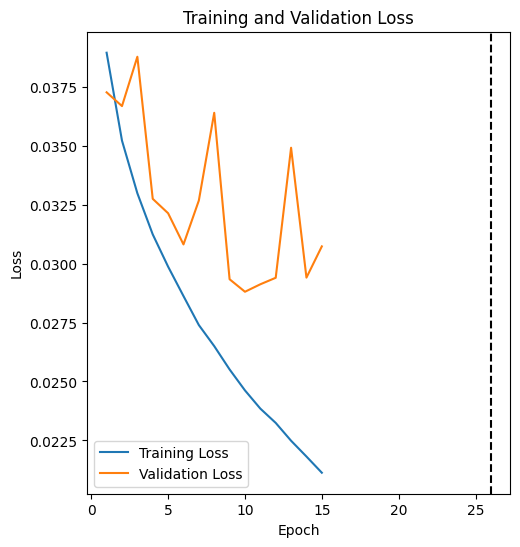

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
# Limit the x-axis range to match the length of train_losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')  # Same for val_losses
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.axvline(x=26,color='black',linestyle='--')
plt.legend()


In [ ]:
train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_scores, test_scores, train_mhc_input_ids, test_mhc_input_ids, train_mhc_attention_mask, test_mhc_attention_mask = train_test_split(
    pep_input_ids, pep_attention_mask, scores, mhc_input_ids, mhc_attention_mask, test_size=0.2, random_state=42)

# Further split the temporary data into validation and test sets
train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_scores, val_scores, train_mhc_input_ids, val_mhc_input_ids, train_mhc_attention_mask, val_mhc_attention_mask = train_test_split(
    train_input_ids, train_attention_mask, train_scores, train_mhc_input_ids, train_mhc_attention_mask, test_size=0.2, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(train_input_ids, train_attention_mask, train_mhc_input_ids, train_mhc_attention_mask, train_scores)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

val_data = TensorDataset(val_input_ids, val_attention_mask, val_mhc_input_ids, val_mhc_attention_mask, val_scores)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)

test_data = TensorDataset(test_input_ids, test_attention_mask, test_mhc_input_ids, test_mhc_attention_mask, test_scores)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)


In [ ]:
# Load the model
model = TCNModel(model_dim=256, num_layers=3, dropout=0.1, vocab_size=33).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/tcn_best_model.pth',weights_only=True))
model.eval()  # Set the model to evaluation mode

y_true_test = []
y_pred_test = []
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        pep_input_ids_batch, pep_attention_mask_batch, mhc_input_ids_batch, mhc_attention_mask_batch, scores_batch = batch
        outputs = model(pep_input_ids_batch, mhc_input_ids_batch)

        # Calculate test loss
        test_loss += criterion(outputs.squeeze(), scores_batch).item()

        y_true_test.extend(scores_batch.cpu().numpy())
        y_pred_test.extend(outputs.cpu().numpy())

# Convert y_true_test and y_pred_test to NumPy arrays
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

avg_test_loss = test_loss / len(test_loader)
test_mse = mean_squared_error(y_true_test, y_pred_test)
test_mae = mean_absolute_error(y_true_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
r2_test = r2_score(y_true_test, y_pred_test)

print(f"Test R²: {r2_test}")
print(f"Test Loss: {avg_test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")

Test R²: 0.6234221458435059
Test Loss: 0.02589979067090012
Test MSE: 0.025897283107042313
Test MAE: 0.12212396413087845
Test RMSE: 0.16092632819722916


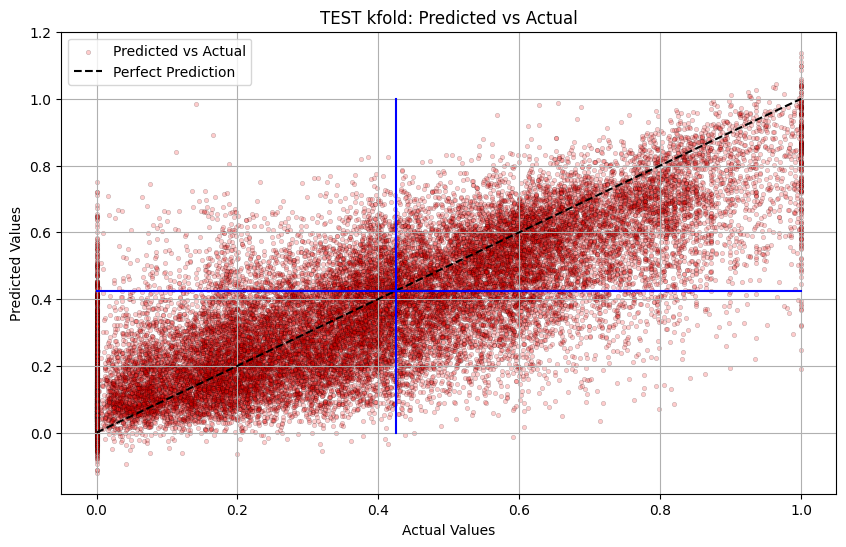

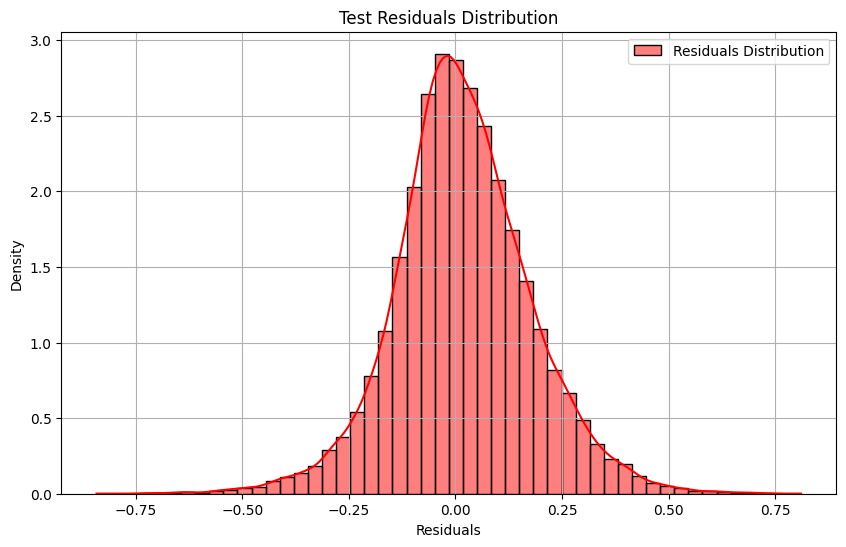

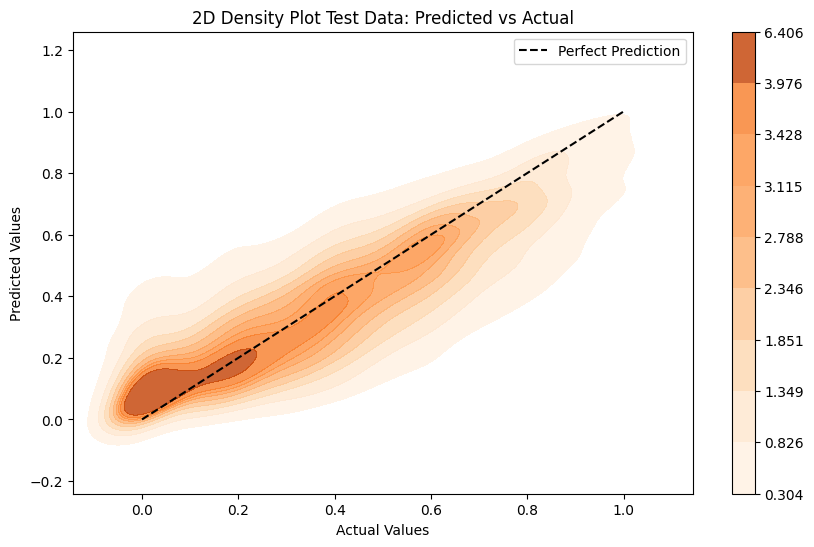

In [ ]:
plt.figure(figsize=(10, 6))
#y_pred_test is likely multidimensional, so squeeze it
sns.scatterplot(x=y_true_test, y=y_pred_test.squeeze(), color='red', s=10, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], color='black', linestyle='--', label='Perfect Prediction') #use y_true_test here, not y_true
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST kfold: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# Plot Residuals Distribution
kfold_residuals = np.array(y_true_test) - np.array(y_pred_test.squeeze())
plt.figure(figsize=(10, 6))
sns.histplot(kfold_residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2D Density
plt.figure(figsize=(10, 6))
#y_pred_test is likely multidimensional, so squeeze it
sns.kdeplot(x=y_true_test, y=y_pred_test.squeeze(), cmap="Oranges", fill=True, levels=10, alpha=0.8, cbar=True)
plt.plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], color='black', linestyle='--', label='Perfect Prediction') #use y_true_test here, not y_true
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()
plt.show()

In [ ]:
train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_scores, test_scores, train_mhc_input_ids, test_mhc_input_ids, train_mhc_attention_mask, test_mhc_attention_mask = train_test_split(
    pep_input_ids, pep_attention_mask, scores, mhc_input_ids, mhc_attention_mask, test_size=0.2, random_state=42)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float("inf")
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores, rmse_scores = [], [], [], []
best_models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_input_ids)):
    print(f"Fold {fold + 1}")

    train_data = TensorDataset(train_input_ids[train_idx], train_attention_mask[train_idx], train_mhc_input_ids[train_idx], train_mhc_attention_mask[train_idx], train_scores[train_idx])
    val_data = TensorDataset(train_input_ids[val_idx], train_attention_mask[val_idx], train_mhc_input_ids[val_idx], train_mhc_attention_mask[val_idx], train_scores[val_idx])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    model = TCNModel(model_dim=256, num_layers=3, dropout=0.2, vocab_size=33).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=5)

    best_loss = float("inf")
    best_model_path = f'/content/drive/MyDrive/best_model_tcn_fold_{fold}.pth'

    for epoch in range(100):
        model.train()
        for batch in train_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, scores_batch = batch
            optimizer.zero_grad()
            outputs = model(pep_input_ids_batch, mhc_input_ids_batch)
            loss = criterion(outputs.squeeze(), scores_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        y_true, y_pred = [], []
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                pep_input_ids_batch, _, mhc_input_ids_batch, _, scores_batch = batch
                outputs = model(pep_input_ids_batch, mhc_input_ids_batch)
                loss = criterion(outputs.squeeze(), scores_batch)
                val_loss += loss.item()
                y_true.extend(scores_batch.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)

        if early_stopping.should_stop(val_loss):
            break
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    best_models.append(best_model_path)
    fold_mse = mean_squared_error(y_true, y_pred)
    fold_mae = mean_absolute_error(y_true, y_pred)
    fold_rmse = np.sqrt(fold_mse)
    fold_r2 = r2_score(y_true, y_pred)

    r2_scores.append(fold_r2)
    mse_scores.append(fold_mse)
    mae_scores.append(fold_mae)
    rmse_scores.append(fold_rmse)

    print(f'Fold {fold+1} - R²: {fold_r2:.4f}, MSE: {fold_mse:.4f}, MAE: {fold_mae:.4f}, RMSE: {fold_rmse:.4f}')

print(f"Average R²: {np.mean(r2_scores):.4f}, MSE: {np.mean(mse_scores):.4f}, MAE: {np.mean(mae_scores):.4f}, RMSE: {np.mean(rmse_scores):.4f}")


Fold 1
Fold 1 - R²: 0.6224, MSE: 0.0259, MAE: 0.1218, RMSE: 0.1609
Fold 2
Fold 2 - R²: 0.6061, MSE: 0.0268, MAE: 0.1263, RMSE: 0.1638
Fold 3
Fold 3 - R²: 0.6214, MSE: 0.0258, MAE: 0.1212, RMSE: 0.1606
Fold 4
Fold 4 - R²: 0.6072, MSE: 0.0271, MAE: 0.1250, RMSE: 0.1646
Fold 5
Fold 5 - R²: 0.6069, MSE: 0.0268, MAE: 0.1259, RMSE: 0.1638
Average R²: 0.6128, MSE: 0.0265, MAE: 0.1240, RMSE: 0.1627


In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Initialize lists to store predictions and true values
ensemble_preds = []
y_true = []  # Initialize y_true outside the loop

# Get the true values for the test data only once
with torch.no_grad():
    for batch in test_loader:
        _, _, _, _, true_scores = batch  # Get true scores
        y_true.extend(true_scores.cpu().numpy())  # Store true values

y_true = np.array(y_true)  # Convert to numpy array

# Loop through folds (0 to 4) to load models and make predictions
for fold in range(5):
    model_path = f'/content/drive/MyDrive/best_model_tcn_fold_{fold}.pth'

    model = TCNModel(model_dim=256, num_layers=3, dropout=0.2, vocab_size=33).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=False))  # Load model to the correct device
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for batch in test_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, _ = batch  # No need to get true scores again

            # Forward pass to get predictions
            outputs = model(pep_input_ids_batch, mhc_input_ids_batch)
            fold_preds.append(outputs.cpu().numpy())  # Store predicted values

    # Convert predictions from list of batches to numpy array
    fold_preds = np.concatenate(fold_preds, axis=0)

    # Add fold predictions to the ensemble
    ensemble_preds.append(fold_preds)

# Convert to numpy arrays
ensemble_preds = np.concatenate(ensemble_preds, axis=0)  # Shape: (num_folds * num_samples,)

# Average predictions from all models
y_pred = np.mean(ensemble_preds.reshape(5, -1), axis=0)  # Reshape for averaging across folds

# Compute test metrics
test_r2 = r2_score(y_true, y_pred)
test_mse = mean_squared_error(y_true, y_pred)
test_mae = mean_absolute_error(y_true, y_pred)
test_rmse = np.sqrt(test_mse)

# Print metrics
print(f'Ensemble Test R² Score: {test_r2:.4f}')
print(f'Ensemble Test MSE: {test_mse:.4f}')
print(f'Ensemble Test MAE: {test_mae:.4f}')
print(f'Ensemble Test RMSE: {test_rmse:.4f}')

Ensemble Test R² Score: 0.6508
Ensemble Test MSE: 0.0240
Ensemble Test MAE: 0.1178
Ensemble Test RMSE: 0.1550


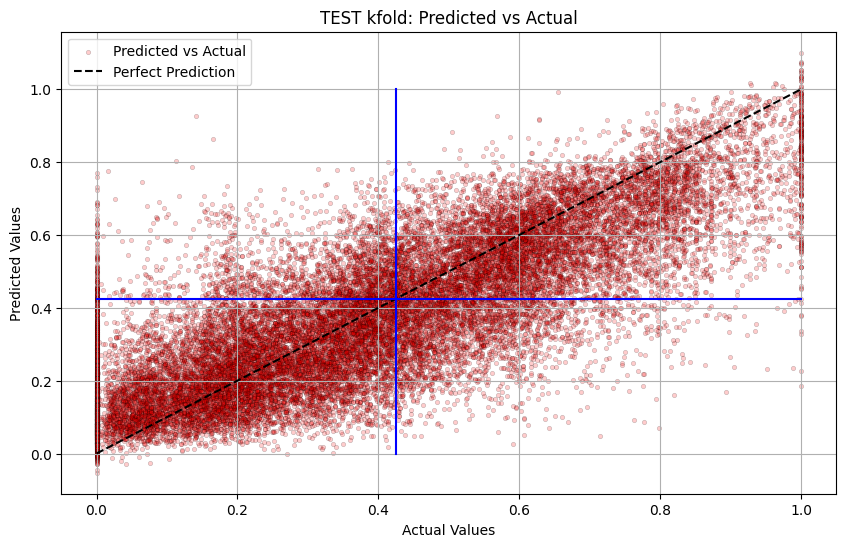

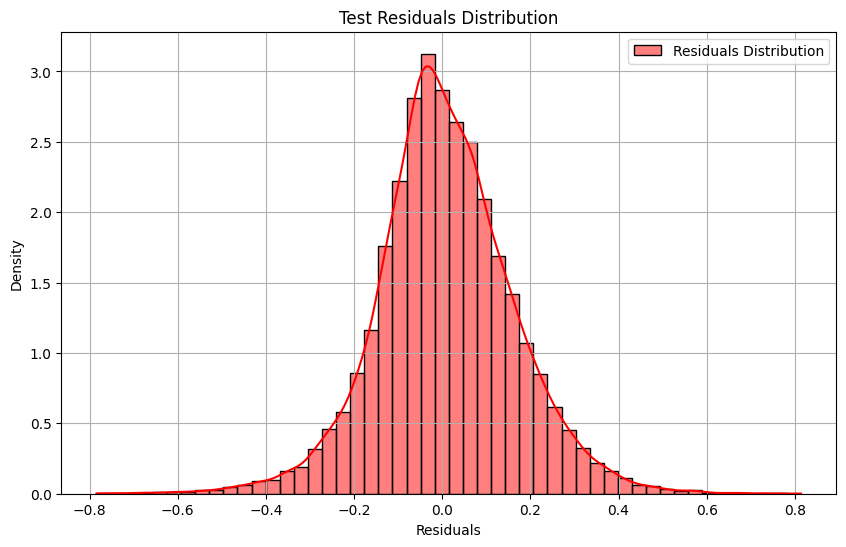

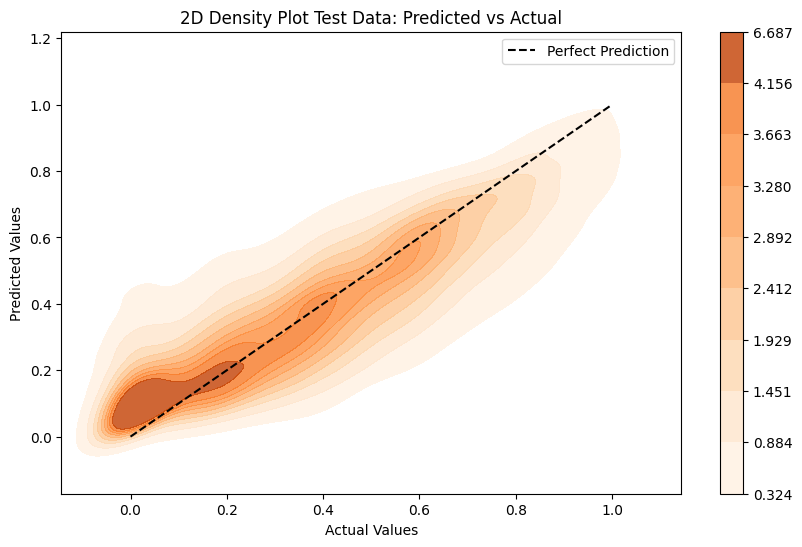

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true, y=y_pred.squeeze(), color='red', s=10, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST kfold: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# Plot Residuals Distribution
kfold_residuals = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(10, 6))
sns.histplot(kfold_residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2D Density
plt.figure(figsize=(10, 6))
sns.kdeplot(x=y_true, y=y_pred.squeeze(), cmap="Oranges", fill=True, levels=10, alpha=0.8, cbar=True)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()
plt.show()
